# Parabolic approximation to free energies

We gotts find $a(T),b(T),c(T)$ (for each phase) such that

$$p(X_{Cr},T) = a(T)X_{Cr}^2 + b(T)X_{Cr} +c(T)$$

is a good approximation to the free energy density $f = \frac{G}{V_m}$.

Here, "good" approximation means satisfying the following conditions:

1. $$f(x_{s/l},T) = p(x_{s/l},T)$$.

2. $$\frac{\partial f(x,T)}{\partial x} \bigg|_{x_{s/l}}= \frac{\partial p(x,T)}{\partial x} \bigg|_{x_{s/l}}$$.

3. $$\frac{\partial^2 f(x,T)}{\partial x^2} \bigg|_{x_{s/l}}= \frac{\partial^2 p(x,T)}{\partial x^2} \bigg|_{x_{s/l}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Define standard gibbs energies of components

R = 8.31448
V_m = 7.09e-6 #m^3/mol

def G0_Cr_bcc(T):
    
    # -439.0 to account for difference in standard enthalpies
    
    return (T<2180)*(-439.0 -8851.93 + 157.48*T -26.908*T*np.log(T) + 1.89435E-3 * T**2 -1.47721E-6*T**3 + 139250/T) +\
    (T>=2180)*(-34864+344.18*T-50*T*np.log(T)-2.88526E32/T**9)

def G0_Fe_bcc(T):
    
    return (T<1811)*(1224.83 + 124.134*T - 23.5143*T*np.log(T) -4.3975E-3 * T**2 - 5.89269E-8*T**3 + 77358.5/T) +\
    (T>=1811)*(-25384.451+299.31255*T -46*T*np.log(T) +2.2960305E31/T**9)


def G0_Fe_liq(T):
    
    return (T<1811)*(G0_Fe_bcc(T) + 12040.17 - 6.55843*T - 3.6751551E-21*T**7) +\
    (T>=1811)*(-10839.7+291.302*T-46*T*np.log(T))

def G0_Cr_liq(T):
    
    return (T<2180)*(G0_Cr_bcc(T) + 24335.93 - 11.42*T + 2.37615E-21*T**7) +\
    (T>=2180)*(-16459+335.618*T-50*T*np.log(T))


# Excess terms

def Gxs_bcc(x,T):
    
    return x*(1-x)*(20500-9.68*T)

def Gxs_liq(x,T):
    
    return x*(1-x)*(-14550+6.65*T)

# Magnetic Term

def GM(x,T):
    
    Tc = 1043*(1-x) - 311.5*x + x*(1-x)*(1650+550*(2*x-1))
    t = T/Tc
    b = 2.22*(1-x) - 0.008*x -x*(1-x)*0.85
    
    # different equations for t>1 and t<1
        
    f = (t>1)*(-6.417E-2/t**5 - 2.037E-3/t**15 -4.278E-4/t**25) +\
    (t<=1)*(-0.90530/t +1.0 + 0.153*t**3 - 6.8E-3*t**9 - 1.53E-3*t**15)

    
    return R*T*np.log(b+1)*f

In [3]:
# Free energy densities (in J/cm^3)

def f_bcc(x,T):
    
    return (x*G0_Cr_bcc(T) + (1-x)*G0_Fe_bcc(T) + R*T*(x*np.log(x)+(1-x)*np.log(1-x))+ Gxs_bcc(x,T) + GM(x,T))/V_m

def f_liq(x,T):
    
    return (x*G0_Cr_liq(T) + (1-x)*G0_Fe_liq(T) + R*T*(x*np.log(x)+(1-x)*np.log(1-x)) + Gxs_liq(x,T))/V_m

In [4]:
# First derivatives (J/cm^4)

def dfdx_bcc(x,T):
    
    Tc = 1043*(1-x) - 311.5*x + x*(1-x)*(1650+550*(2*x-1))
    t = T/Tc
    
    b = 2.22*(1-x) - 0.008*x -x*(1-x)*0.85
    f = (t>1)*(-6.417E-2/t**5 - 2.037E-3/t**15 -4.278E-4/t**25) +\
    (t<=1)*(-0.90530/t +1.0 + 0.153*t**3 - 6.8E-3*t**9 - 1.53E-3*t**15)
    
    dbdx = -2.228 + (2*x-1)*0.85
    dGMdx = R*T/(b+1)*f*dbdx
    
    return (G0_Cr_bcc(T) - G0_Fe_bcc(T) + R*T*(np.log(x/(1-x))) + (1-2*x)*(20500-9.68*T) + dGMdx)/V_m

def dfdx_liq(x,T):

    return (G0_Cr_liq(T) - G0_Fe_liq(T) + R*T*(np.log(x/(1-x))) +\
    (1-2*x)*(-14450+6.65*T))/V_m

In [5]:
# Second derivatives (J/cm^4)

def d2fdx2_bcc(x,T):
    
    Tc = 1043*(1-x) - 311.5*x + x*(1-x)*(1650+550*(2*x-1))
    t = T/Tc
    
    b = 2.22*(1-x) - 0.008*x -x*(1-x)*0.85
    f = (t>1)*(-6.417E-2/t**5 - 2.037E-3/t**15 -4.278E-4/t**25) +\
    (t<=1)*(-0.90530/t +1.0 + 0.153*t**3 - 6.8E-3*t**9 - 1.53E-3*t**15)
    
    dbdx = -2.228 + (2*x-1)*0.85
    d2bdx2 = 2*0.85
    
    dGMdx = R*T/(b+1)*f*dbdx
    d2GMdx2 = -R*T/(b+1)**2 * f * dbdx**2 + R*T/(b+1)*f*d2bdx2
    
    return (R*T/(x*(1-x)) -2*(20500-9.68*T) + d2GMdx2)/V_m

def d2fdx2_liq(x,T):

    return (R*T/(x*(1-x)) -2*(-14450+6.65*T))/V_m

## Solving for parabolic constants

$$p(X_{Cr},T) = a(T)X_{Cr}^2 + b(T)X_{Cr} +c(T)$$ Let's take $x=X_{Cr}$

$$\frac{\partial p}{\partial x} = 2a(T)x + b(T)$$

$$\frac{\partial^2p}{\partial x^2} = 2a(T)$$

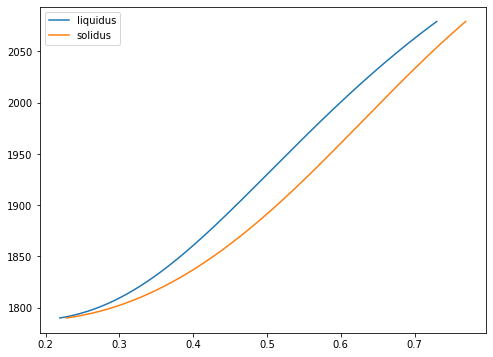

In [6]:
# load data and plot phase diagram

data = np.genfromtxt('eq_data.csv',delimiter=',')
data = data[data[:,0]<2080]

fig,ax = plt.subplots(figsize=(8,6))

ax.plot(data[:,1],data[:,0],label='liquidus')
ax.plot(data[:,2],data[:,0],label='solidus')
ax.legend()

In [7]:
bcc_consts = []
liq_consts = []

for pt in data:
    
    T = pt[0]
    x_l = pt[1]
    x_s = pt[2]
    
    #bcc
    a_bcc = d2fdx2_bcc(x_s,T)/2
    b_bcc = dfdx_bcc(x_s,T) - 2*a_bcc*x_s
    c_bcc = f_bcc(x_s,T) - a_bcc*x_s**2 - b_bcc*x_s
    
    #liquid
    a_liq = d2fdx2_liq(x_l,T)/2
    b_liq = dfdx_liq(x_l,T) - 2*a_liq*x_l
    c_liq = f_liq(x_l,T) - a_liq*x_l**2 - b_liq*x_l
    
    bcc_consts.append([T,a_bcc,b_bcc,c_bcc])
    liq_consts.append([T,a_liq,b_liq,c_liq])

In [8]:
bcc_consts = np.array(bcc_consts)
liq_consts = np.array(liq_consts)

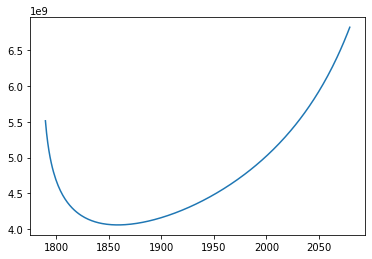

In [9]:
plt.plot(bcc_consts[:,0],bcc_consts[:,1])

In [10]:
@interact(i=(0,100))
def plotfn(i):
    
    xs = np.linspace(0.05,0.9)
    T = bcc_consts[i][0]
    
    x_l = data[i][1]
    x_s = data[i][2]
    
    fig,ax = plt.subplots(figsize=(10,8))

    ax.plot(xs,f_bcc(xs,T),label='BCC')
    ax.plot(xs,f_liq(xs,T),label='liq')
    ax.plot(xs,np.polyval(bcc_consts[i][1:],xs),label='BCC_appx',linestyle='--')
    ax.plot(xs,np.polyval(liq_consts[i][1:],xs),label='liq_appx',linestyle='--')
    
    ax.axvline(x_l)
    ax.axvline(x_s)
    ax.legend()

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

In [11]:
np.savetxt('bcc_consts.csv',bcc_consts,delimiter=',')
np.savetxt('liq_consts.csv',liq_consts,delimiter=',')

## Polynomial fits to the constants

The constants were fitted to a 7th order polynomial in T using SciDavis. **Note: This will only work for the given temperature range (1790-2080K). Polynomials extrapolate badly**

In [12]:
def a_bcc_poly(T):
    
    a0  = 1.48573160876362e+17
    a1  = -533959921453932
    a2  = 822132803086.902
    a3  = -702980512.848244
    a4  = 360524.747722819
    a5  = -110.896060621478
    a6  = 0.0189435512365575
    a7  = -1.38632597908866e-06
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


def b_bcc_poly(T):
    
    a0  = -5.74988758596428e+16
    a1  = 205888139888278
    a2  = -315807244126.921
    a3  = 268986846.012062
    a4  = -137396.890145104
    a5  = 42.0876190128756
    a6  = -0.00715869712372715
    a7  = 5.21561342179072e-07
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def c_bcc_poly(T):
    
    a0  = 2.24280665461153e+15
    a1  = -7672646510499.51
    a2  = 11198716987.0004
    a3  = -9033989.94168094
    a4  = 4346.56671776632
    a5  = -1.24600097323119
    a6  = 0.000196784418722745
    a7  = -1.31853064948386e-08
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


def a_liq_poly(T):
    
    a0  = 1.34402214639946e+17
    a1  = -483041743694295
    a2  = 743752241655.028
    a3  = -635975330.764811
    a4  = 326169.32777634
    a5  = -100.331108793173
    a6  = 0.0171392878798394
    a7  = -1.25432210980197e-06
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def b_liq_poly(T):
    
    a0  = -5.02636054089711e+16
    a1  = 180002914938405
    a2  = -276136627305.307
    a3  = 235226732.682717
    a4  = -120167.335429361
    a5  = 36.8144381507289
    a6  = -0.00626257159618173
    a7  = 4.56330855404118e-07
    
    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7

def c_liq_poly(T):
    
    a0  = 2.12467464521575e+15
    a1  = -7310151586822.15
    a2  = 10738897653.4874
    a3  = -8727402.7907034
    a4  = 4235.13227776304
    a5  = -1.22627109914018
    a6  = 0.00019598329226659
    a7  = -1.33213290371344e-08

    return a0+a1*T+a2*T**2+a3*T**3+a4*T**4+a5*T**5+a6*T**6+a7*T**7


In [13]:
c_liq_poly(1801)

-15402335003.625

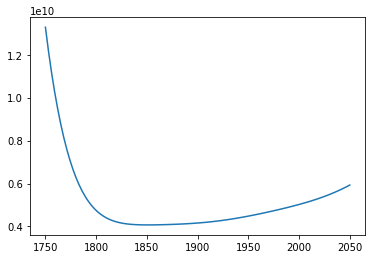

In [14]:
Tees = np.linspace(1750,2050,100)
plt.plot(Tees,a_bcc_poly(Tees))

In [15]:
# Now, for the approximate free energies

def f_bcc_appx(x,T):
    
    a = a_bcc_poly(T)
    b = b_bcc_poly(T)
    c = c_bcc_poly(T)
    
    return a*x**2 + b*x + c

def f_liq_appx(x,T):
    
    a = a_liq_poly(T)
    b = b_liq_poly(T)
    c = c_liq_poly(T)
    
    return a*x**2 + b*x + c

In [16]:
@interact(i=(0,100))
def plotfn(i):
    
    xs = np.linspace(0.05,0.9)
    T = bcc_consts[i][0]
    
    x_l = data[i][1]
    x_s = data[i][2]
    
    fig,ax = plt.subplots(figsize=(10,8))

    ax.plot(xs,f_bcc(xs,T),label='BCC')
    ax.plot(xs,f_liq(xs,T),label='liq')
    ax.plot(xs,f_bcc_appx(xs,T),label='BCC_appx',linestyle='--')
    ax.plot(xs,f_liq_appx(xs,T),label='liq_appx',linestyle='--')
    ax.set_title('T = ' + str(T))
    
    ax.axvline(x_l)
    ax.axvline(x_s)
    ax.legend()

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

In [17]:
# First, we take at composition X_l = 0.4
pt = 64  # index of eq. temperature for given liquid composition
uc = 64

print(data[pt,:])
print(data[uc,:])

[1.86040000e+03 3.99549500e-01 4.47110358e-01]
[1.86040000e+03 3.99549500e-01 4.47110358e-01]


In [18]:
print(bcc_consts[uc])
print(liq_consts[uc])
print(data[pt])

[ 1.86040000e+03  4.06198909e+09 -1.70487317e+09 -1.63146625e+10]
[ 1.86040000e+03  4.84005762e+09 -1.94024359e+09 -1.63540194e+10]
[1.86040000e+03 3.99549500e-01 4.47110358e-01]


In [19]:
# Chem potentials at Undercooled temperature
# For equilibrium compositions at original temperature.

# mu_s

print(2*bcc_consts[uc][1]*data[pt][2] + bcc_consts[uc][2])

# mu_l

print(2*liq_consts[uc][1]*data[pt][1] + liq_consts[uc][2]) 

1927441623.5438719
1927441623.5438724
